# 使用Gluon对CIFAR10进行分类

In [13]:
import mxnet as mx
import numpy as np
import utils
import os
import shutil

from mxnet import nd
from mxnet import gluon
from mxnet import image 
from mxnet import metric
from mxnet import autograd

%matplotlib inline 
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt

ctx_list = [mx.cpu()]

## 整理数据

In [14]:
def reorg_cifar10(data_dir, train_dir, test_dir, input_dir, label_file, valid_ratio):
    # 整理label
    with open(os.path.join(data_dir, label_file), 'r') as f:
        label_file = f.readlines()[1:]
        tokens = [l.rstrip().split(',') for l in label_file]
        idx_label = dict((int(idx), label) for idx, label in tokens)
    labels = set(idx_label.values())
    
    # 设置验证集比例
    num_train = len(os.listdir(os.path.join(data_dir, train_dir)))
    num_train_tuning = num_train * (1 - valid_ratio)
    assert 0 < num_train_tuning < num_train
    num_train_tuning_per_label = num_train_tuning // len(labels)
    
    # 整理训练集和验证集
    label_count = dict()
    def mkdir_if_not_exist(path):
        if not os.path.exists(os.path.join(*path)):
            os.makedirs(os.path.join(*path))
            
    for train_file in os.listdir(os.path.join(data_dir, train_dir)):
        idx = int(train_file.split('.')[0])
        train_label = idx_label[idx]
        mkdir_if_not_exist([data_dir, input_dir, 'train_valid', label])
        shutil.copy(os.path.join(data_dir, train_dir, train_file),
                   os.path.join(data_dir, input_dir, 'train_valid', label))
        # 划分训练集和验证集
        if label not in label_count or label_count[label] < num_train_tuning_per_label:
            mkdir_if_not_exist([data_dir, input_dir, 'train', label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                       os.path.join(data_dir, input_dir, 'train', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            mkdir_if_not_exist([data_dir, input_dir, 'valid', label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                       os.path.join(data_dir, input_dir, 'valid', label))
    
    # 整理测试集
    mkdir_if_not_exist([data_dir, input_dir, 'test', 'unknown'])
    for test_file in os.listdir(os.path.join(data_dir, test_dir)):  
        shutil.copy(os.path.join(data_dir, test_dir, test_file),
                   os.path.join(data_dir, input_dir, 'test', 'unknown'))

In [15]:
data_dir = '../data/kaggle_cifar10'
train_dir = 'train'
test_dir = 'test'
input_dir = 'train_valid_test'
label_file = 'trainLabels.csv'
valid_ratio = .1

if not os.path.exists(os.path.join(data_dir, input_dir, test_dir)):
    reorg_cifar10(data_dir, train_dir, test_dir, input_dir, label_file, valid_ratio)

## 读取数据并增广

In [16]:
train_augs = [
    image.ColorNormalizeAug(mean=nd.array([0.4914, 0.4822, 0.4456]), 
                            std=nd.array([0.2023, 0.1994, 0.2010])),
    image.HorizontalFlipAug(.6),
    image.BrightnessJitterAug(.5),
    # image.ColorJitterAug
]

test_augs = [
    image.ColorNormalizeAug(mean=nd.array([0.4914, 0.4822, 0.4456]), 
                            std=nd.array([0.2023, 0.1994, 0.2010]))
]

def transform(data, label, augs):
    img = data.astype(np.float32)
    for aug in augs:
        img = aug(img)
    img = img.clip(0, 255).transpose((2,0,1)) / 255
    return img, nd.array([label]).asscalar().astype(np.float32)

input_str = data_dir + '/' + input_dir + '/'

# 读取数据
train_ds = gluon.data.vision.ImageFolderDataset(input_str + 'train',
                                             transform=lambda X, y : transform(X, y, train_augs))
valid_ds = gluon.data.vision.ImageFolderDataset(input_str + 'valid',
                                           transform=lambda X, y : transform(X, y, test_augs))
train_valid_ds = gluon.data.vision.ImageFolderDataset(input_str + 'train_valid',
                                             transform=lambda X, y : transform(X, y, train_augs))
test_ds = gluon.data.vision.ImageFolderDataset(input_str + 'test', 
                                      transform=lambda X, y : transform(X, y, test_augs))

batch_size = 128
train_data = gluon.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, last_batch='keep')
valid_data = gluon.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True, last_batch='keep')
train_valid_data = gluon.data.DataLoader(train_valid_ds, batch_size=batch_size, last_batch='keep')
test_data = gluon.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, last_batch='keep')

(128, 3, 32, 32)


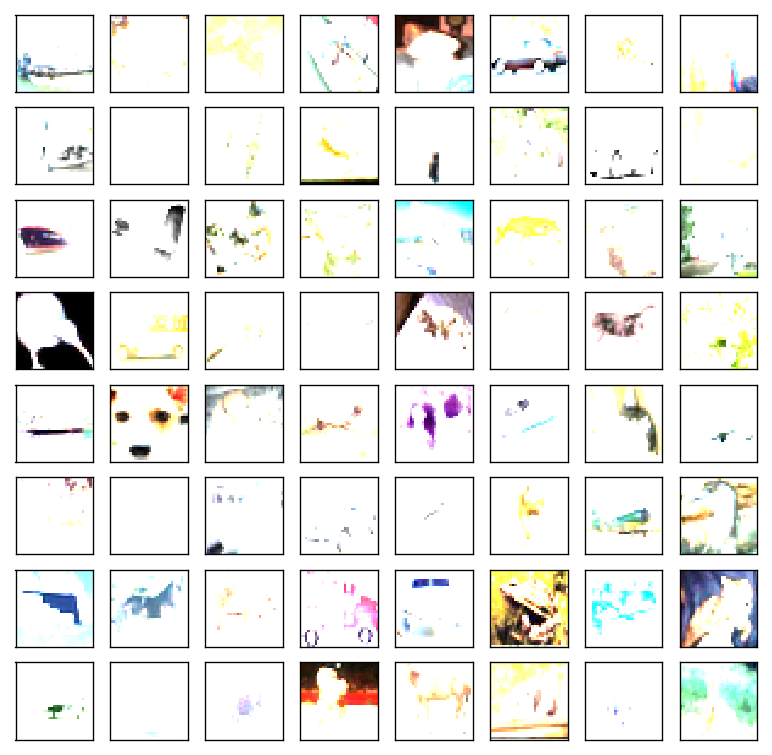

In [17]:
for data, label in valid_data:
    print(data.shape)
    break

utils.show_images(data.transpose((0,2,3,1)), 8, 8, figsize=(8,8))

## ResNet18_V2 (Third)

<img src="../img/Chapter4-Convolutional-Neural-Networks/4-17.png" width="700">

In [18]:
def BN_ReLU_CONV(channels, kernel_size, strides=1, padding=0):
    net = gluon.nn.HybridSequential()
    with net.name_scope():
        net.add(
            gluon.nn.BatchNorm(axis=1),
            gluon.nn.Activation('relu'),
            gluon.nn.Conv2D(channels, kernel_size=kernel_size, strides=strides, padding=padding)
        )
    return net

class Residual(gluon.HybridBlock):
    def __init__(self, channels, shape_inc=False, **kwargs):
        super().__init__(**kwargs)
        self.shape_inc = shape_inc
        strides = 2 if shape_inc else 1
        self.residual = gluon.nn.HybridSequential()
        self.residual.add(
            BN_ReLU_CONV(channels, kernel_size=3, strides=strides, padding=1),
            BN_ReLU_CONV(channels, kernel_size=3, padding=1)
        )
        if self.shape_inc:
            self.cutdown_conv = gluon.nn.Conv2D(channels, kernel_size=1, strides=strides)
    
    def hybrid_forward(self, F, X):
        out = self.residual(X)
        if self.shape_inc:
            X = self.cutdown_conv(X)
        return out + X
    
class ResNet18_V2(gluon.HybridBlock):
    def __init__(self, num_classes, channel_chain, verbose=False, **kwargs):
        super().__init__(**kwargs)
        self.verbose = verbose
        with self.name_scope():
            b1 = gluon.nn.HybridSequential()
            b1.add(
                gluon.nn.Conv2D(channel_chain[0], kernel_size=3, strides=1, padding=1),
                gluon.nn.BatchNorm(axis=1),
                gluon.nn.Activation('relu')
            )
            b2 = gluon.nn.HybridSequential()
            b2.add(
                Residual(channel_chain[0]),
                Residual(channel_chain[0]),
            )
            b3 = gluon.nn.HybridSequential()
            b3.add(
                Residual(channel_chain[1], shape_inc=True),
                Residual(channel_chain[1]),
            )
            b4 = gluon.nn.HybridSequential()
            b4.add(
                Residual(channel_chain[2], shape_inc=True),
                Residual(channel_chain[2])
            )
            b5 = gluon.nn.HybridSequential()
            b5.add(
                Residual(channel_chain[3], shape_inc=True),
                Residual(channel_chain[3])
            )
            b6 = gluon.nn.HybridSequential()
            b6.add(
                gluon.nn.GlobalAvgPool2D(),
                gluon.nn.Dense(num_classes)
            )
        self.net = gluon.nn.HybridSequential()
        self.net.add(b1, b2, b3, b4, b5, b6)
        
    def hybrid_forward(self, F, X):
        out = X
        for i, blk in enumerate(self.net):
            out = blk(out)
#             if self.verbose:
#                 print("blk %d : %s" % ((i+1), out.shape))
        return out

In [19]:
resnet18 = ResNet18_V2(num_classes=10, channel_chain=[32, 64, 128, 256], verbose=True)
resnet18.initialize()
X = nd.random.uniform(shape=(1,3,32,32))
y = resnet18(X)

In [20]:
from time import time 

def train(net, train_data, valid_data, num_epochs, lr, wd, lr_period, lr_decay, ctx):
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'wd': wd})
    
    niter = 0
    moving_loss = .0
    smoothing_constant = .9
    
    for epoch in range(num_epochs):
        train_data.reset()
        if not epoch % lr_period:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        start = time()
        for data_batch, label_batch in train_data:
            data_batch = gluon.utils.split_and_load(data_batch, ctx_list=ctx, batch_axis=0)
            label_batch = gluon.utils.split_and_load(label_batch, ctx_list=ctx, batch_axis=0)
            
            Ls = []
            with autograd.record():
                for data, label in zip(data_batch, label_batch):
                    output = net(data)
                    L = loss(output, label)
                    Ls.append(L)
                for ls in Ls:
                    ls.backward()
                trainer.step(data_batch.shape[0])

            # moving loss
            niter += 1
            for ls in Ls:
                curr_loss += nd.mean(ls).asscalar()
            moving_loss = smoothing_constant * moving_loss + (1-smoothing_constant) * curr_loss
            estimated_loss = moving_loss / (1 - smoothing_constant**niter)
            
        train_acc = utils.evaluate_accuracy_gluon(train_data, net, ctx)
        valid_acc, valid_loss = utils.evaluate_accuracy_gluon(valid_data, net, ctx[0])
        print("[Epoch %d] Train Moving Loss : %.5f, Test Loss : .5f, Train Acc : %.5f, Test Acc : %.5f, \
              Time Consume %f." % (epoch, estimated_loss, valid_loss, train_acc, valid_acc, time() - start))

In [190]:
num_epochs = 40
lr = 0.05
wd = 5e-4
lr_period = 10
lr_decay = .1

gpus = 1
ctx_list = [mx.gpu(i) for i in range(gpus)] if gpus > 0 else [mx.cpu()]

resnet18 = ResNet18_V2(num_classes=10, channel_chain=[32, 64, 128, 256], verbose=True)
resnet18.collect_params().initialize(init=mx.init.Xavier(), ctx=ctx_list)
ResNet18.hybridize()
train(resnet18, train_data, valid_data, num_epochs, lr, wd, lr_period, lr_decay, ctx=ctx_list)